In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [22]:
from sklearn.model_selection import train_test_split

# # Data inladen
df = pd.read_csv("final_df.csv")
print(df.head())
# df = groot_gemid_df

# Eerst de data opschudden om bias te voorkomen
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Zorg ervoor dat elke ervaring, geslacht en gewichtsklasse in elke set vertegenwoordigd zijn
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & (df['binary_geslacht'] == geslacht) & (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indexen
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Controleren op juiste verdeling
print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

# Optioneel: data opslaan in aparte bestanden
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print(df['2k tijd'].min())
print(df['2k tijd'].max())

   ervaring  500_split  2k tijd  binary_trainingtype  binary_geslacht  \
0       1.0      104.6    379.9                    0                0   
1       1.0      104.7    379.9                    0                0   
2       1.0      104.3    379.9                    0                0   
3       1.0      104.0    379.9                    0                0   
4       1.0      104.1    379.9                    0                0   

   binary_gewichtsklasse  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen
371.8
510.1


In [23]:
X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

#maakt geen verschil
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

mse = 50.64223629541192
mse_val = 62.9019027812587
rse = 7.116335875674498
[414.7917]
val_r2 = 1.0
test_r2 = 1.0
train_r2 = 1.0
   Actual 2k tijd  Predicted 2k tijd (XGBoost)  Difference (XGBoost)
0           427.7                   428.224243             -0.524243
1           420.5                   428.224243             -7.724243
2           418.6                   428.224243             -9.624243
3           427.7                   428.224243             -0.524243
4           427.7                   428.224243             -0.524243
5           420.5                   428.224243             -7.724243
6           421.9                   428.224243             -6.324243
7           449.0                   428.224243             20.775757
8           431.6                   428.224243              3.375757
9           431.6                   428.224243              3.375757


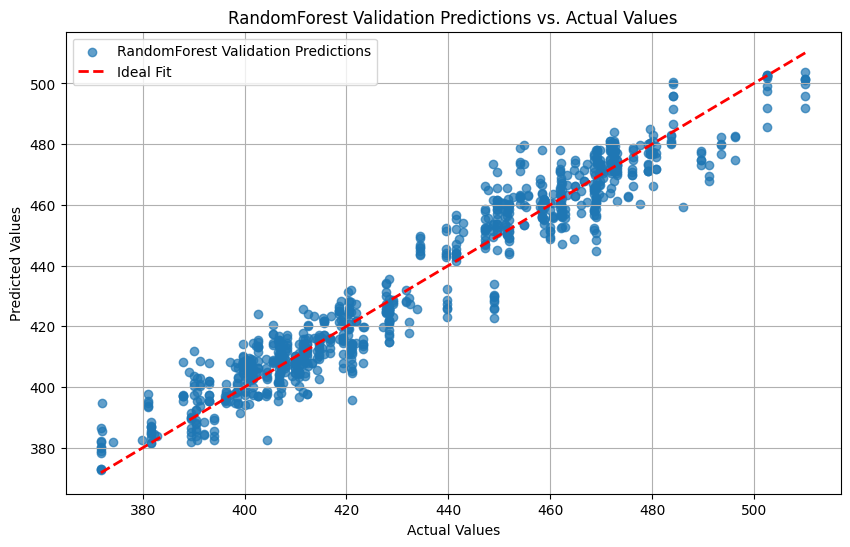

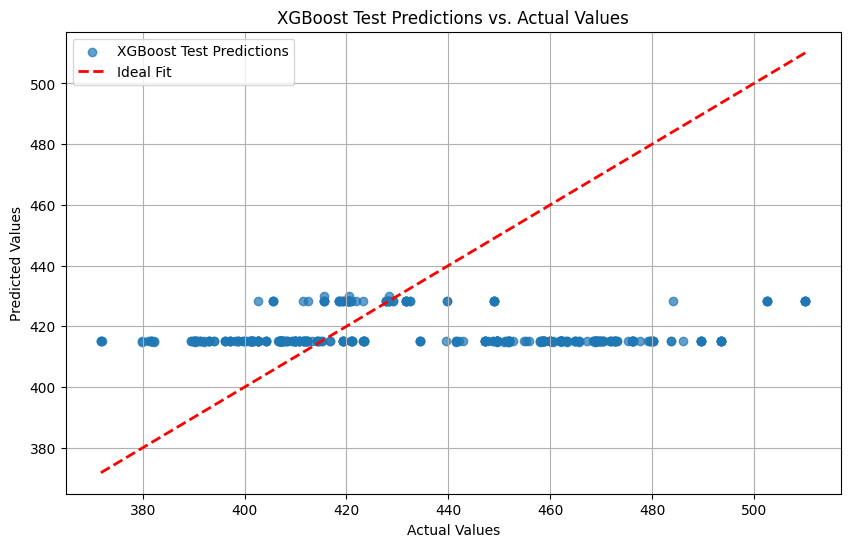

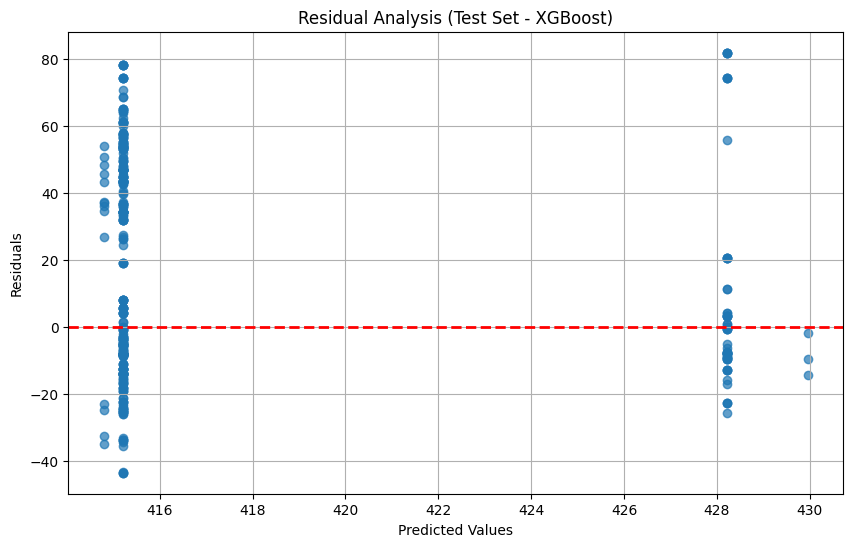

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, reg_lambda=100)

predictions = xgb_model.fit(X_train_scaled, y_train)

predictions = xgb_model.predict(X_test_scaled)

val_pred = xgb_model.predict(X_val_scaled)

mse = mean_squared_error(y_test, predictions)
mse_val = mean_squared_error(y_val, val_pred)
print(f"mse = {mse}")
print(f"mse_val = {mse_val}")

rse = np.sqrt(mse)
print(f"rse = {rse}")

predictions = xgb_model.predict(X_test)
prediction1 = xgb_model.predict(np.array([[1, 104.6, 0, 0, 1]]))
print(prediction1)

val_r2 = r2_score(y_val, y_val)
print(f"val_r2 = {val_r2}")
test_r2 = r2_score(y_test, y_test)
print(f"test_r2 = {test_r2}")
train_r2 = r2_score(y_train, y_train)
print(f"train_r2 = {train_r2}")

results_xgb = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd (XGBoost)': predictions,
    'Difference (XGBoost)': y_test - predictions
})
print(results_xgb.head(10))

# Plot 1: Predictions vs Actual for Validation Set (RandomForest)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_pred, alpha=0.7, label='RandomForest Validation Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest Validation Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()


# Plot 4: Predictions vs Actual for Test Set (XGBoost)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7, label='XGBoost Test Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Test Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Residuals for Test Set (XGBoost)
residuals_xgb = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Test Set - XGBoost)')
plt.grid(True)
plt.show()


In [25]:

param_grid = {'reg_lambda': [0.1, 1, 10, 100, 150, 500]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best lambda (reg_lambda):", grid_search.best_params_['reg_lambda'])


Best lambda (reg_lambda): 100
